In [1]:
import pickle

# Open and load the routerbench_5shot.pkl file
with open('router_states/routerbench_5shot.pkl', 'rb') as f:
    routerbench_data = pickle.load(f)


/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_40638/1371555631.py:5: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  routerbench_data = pickle.load(f)


In [2]:
import pandas as pd

# Configure pandas to show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


In [3]:
routerbench_data['eval_name'].unique()

array(['Chinese_character_riddles', 'abstract2title', 'accounting_audit',
       'arc-challenge', 'bias_detection', 'chinese-lantern-riddles',
       'chinese-remainder-theorem',
       'chinese_ancient_masterpieces_dynasty', 'chinese_ancient_poetry',
       'chinese_chu_ci', 'chinese_famous_novel',
       'chinese_hard_translations', 'chinese_homonym', 'chinese_idioms',
       'chinese_modern_poem_identification', 'chinese_poem',
       'chinese_shi_jing', 'chinese_song_ci', 'chinese_tang_poetries',
       'chinese_zodiac', 'consensus_summary', 'grade-school-math',
       'hellaswag', 'mbpp', 'mmlu-abstract-algebra', 'mmlu-anatomy',
       'mmlu-astronomy', 'mmlu-business-ethics',
       'mmlu-clinical-knowledge', 'mmlu-college-biology',
       'mmlu-college-chemistry', 'mmlu-college-computer-science',
       'mmlu-college-mathematics', 'mmlu-college-medicine',
       'mmlu-college-physics', 'mmlu-computer-security',
       'mmlu-conceptual-physics', 'mmlu-econometrics',
       'mmlu-

In [4]:
mmlu_router = routerbench_data.query('eval_name.str.startswith("mmlu")', engine='python')

In [5]:
mmlu_router = mmlu_router.reset_index(drop = True)

In [6]:
# Find the common start of all MMLU prompts
prompts = mmlu_router['prompt'].tolist()
common_prefix = prompts[0]

for prompt in prompts[1:]:
    # Find first differing character
    for i, (c1, c2) in enumerate(zip(common_prefix, prompt)):
        if c1 != c2:
            common_prefix = common_prefix[:i]
            break
            
# Remove the common prefix from all prompts
mmlu_router['prompt'] = mmlu_router['prompt'].str[len(common_prefix):]




In [7]:
mmlu_router.prompt

0        Find all c in Z_3 such that Z_3[x]/(x^2 + c) i...
1        Find all c in Z_3 such that Z_3[x]/(x^2 + c) i...
2        Find all c in Z_3 such that Z_3[x]/(x^2 + c) i...
3        Find all c in Z_3 such that Z_3[x]/(x^2 + c) i...
4        Find all c in Z_3 such that Z_3[x]/(x^2 + c) i...
                               ...                        
14037     What is the sign of the covenant for Jewish m...
14038     What is the sign of the covenant for Jewish m...
14039     What is the sign of the covenant for Jewish m...
14040     What is the sign of the covenant for Jewish m...
14041     What is the sign of the covenant for Jewish m...
Name: prompt, Length: 14042, dtype: object

In [8]:
# Split mmlu_router into train and test sets with fixed sizes
train_data = mmlu_router.sample(n=1000, random_state=42)
test_data = mmlu_router.drop(train_data.index).sample(n=200, random_state=42)


In [9]:
# Remove duplicate prompts from train and test data
train_data = train_data.drop_duplicates(subset='prompt', keep='first')
test_data = test_data.drop_duplicates(subset='prompt', keep='first')


In [10]:
train_data.loc[5418].prompt

'Ani believes that her attitudes and behavior play a central role in what happens to her. Such a belief is likely to be associated with\\nA) a strong superego.\\nB) low self-esteem.\\nC) low self-efficacy.\\nD) an internal locus of control.\\nPrint only a single choice  from "A" or "B" or "C" or "D" without explanation. Answer:\\nD\\n\\nPlease answer with the letter of the correct answer.\\n\\nAccording to Caplan\\\'s model of consultee-centered case consultation, the consultant is primarily interested in\\nA) identifying the causes and solutions of the client\\\'s presenting problems\\nB) identifying and eliminating the causes of the consultee\\\'s difficulties in handling a problem\\nC) establishing a hierarchy of authority to enable effective decision making\\nD) presenting a single, well-defined and unambiguous course of action for the consultant to overcome skills deficits\\nPrint only a single choice  from "A" or "B" or "C" or "D" without explanation. Answer:\\nB\\n\\nPlease answ

/opt/homebrew/anaconda3/envs/router/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]


(768,)


Batches: 100%|██████████| 38/38 [00:12<00:00,  3.07it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


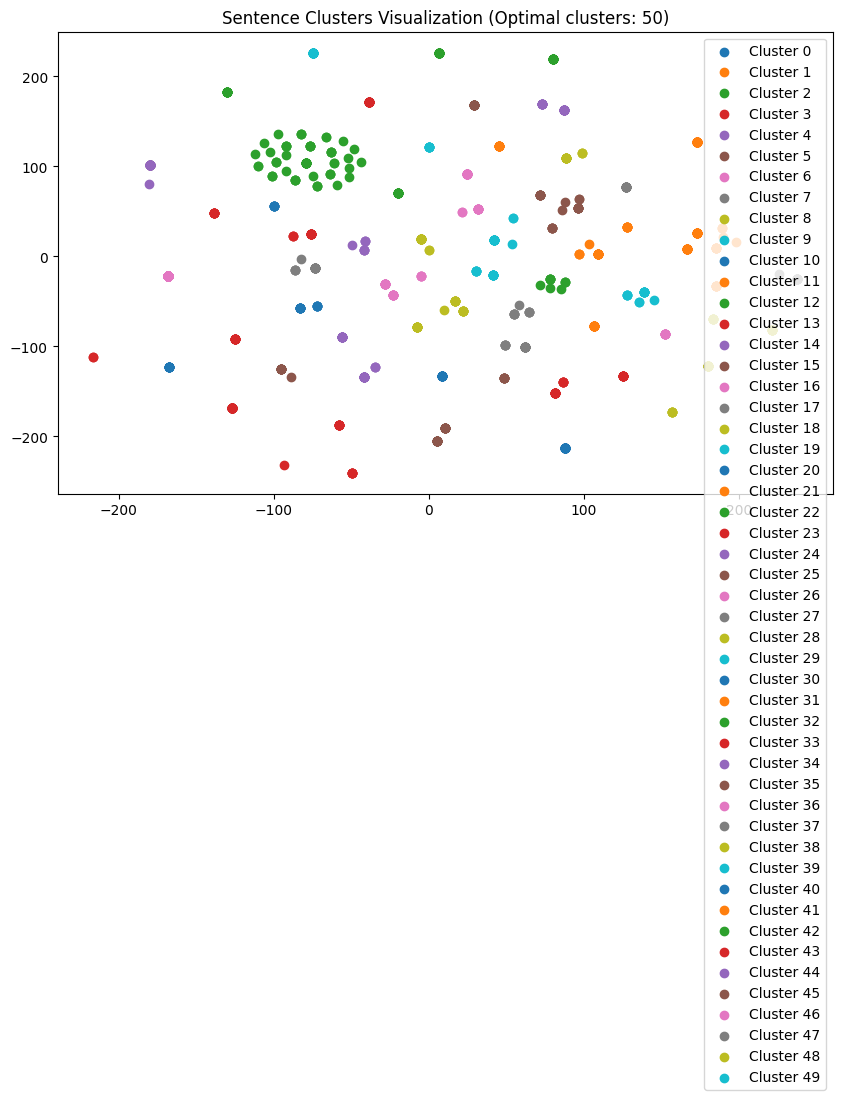

In [11]:
from clustering import cluster_sentences

# Extract sentences from train and test data
train_sentences = train_data['prompt'].tolist()
test_sentences = test_data['prompt'].tolist()

# Combine train and test sentences
all_sentences = train_sentences + test_sentences

# Cluster all sentences together
clusters = cluster_sentences(all_sentences, n_clusters=50, show_graph=True)

# Create a mapping of sentence to cluster ID
sentence_to_cluster = {}
for cluster_id, cluster_data in clusters.items():
    # Each cluster contains list of [sentence, embedding] pairs, except last element which is avg embedding
    for item in cluster_data[:-1]:  # Exclude the last item (average embedding)
        sentence_to_cluster[item[0]] = cluster_id

# Add cluster IDs to train and test dataframes
train_data['cluster_id'] = train_data['prompt'].map(sentence_to_cluster)
test_data['cluster_id'] = test_data['prompt'].map(sentence_to_cluster)


In [19]:
# Sample 3 prompts from cluster 1 and cluster 2
cluster_1_samples = train_data[train_data['cluster_id'] == 1]['prompt'].sample(n=3, random_state=42)
cluster_2_samples = train_data[train_data['cluster_id'] == 2]['prompt'].sample(n=3, random_state=42)

print("Cluster 1 samples:")
print([prompt[-800:] for prompt in cluster_1_samples])
print("\nCluster 2 samples:")
print([prompt[-800:] for prompt in cluster_2_samples])


Cluster 1 samples:
['\\nD) Evaluation of the program\\nPrint only a single choice  from "A" or "B" or "C" or "D" without explanation. Answer:\\nA\\n\\nPlease answer with the letter of the correct answer.\\n\\nEarth Hour was a campaign launched by which organization?\\nA) Greenpeace\\nB) The UN\\nC) Oxfam\\nD) World Wildlife Fund\\nPrint only a single choice  from "A" or "B" or "C" or "D" without explanation. Answer:\\nD\\n\\nPlease answer with the letter of the correct answer.\\n\\nThe ________ phase of the PR process consists of making decisions about which strategies and tactics will be used to respond to the goals of the organization and executing those strategies and tactics.\\nA) tactical\\nB) implementation\\nC) planning\\nD) evaluation\\nPrint only a single choice  from "A" or "B" or "C" or "D" without explanation. Answer:\']', 'environment\\nB) Notify the parents in writing\\nC) Obtain school board approval\\nD) Obtain parental consent\\nPrint only a single choice  from "A" or 

In [20]:
# Create a mapping of prompts to their best performing agents
prompt_to_agent = {}

# Process train data
for idx, row in train_data.iterrows():
    prompt = row['prompt']
    # Get the agent with highest score for this prompt
    best_agent = row['oracle_model_to_route_to']
    prompt_to_agent[prompt] = best_agent

# Process test data 
for idx, row in test_data.iterrows():
    prompt = row['prompt']
    # Get the agent with highest score for this prompt
    best_agent = row['oracle_model_to_route_to']
    prompt_to_agent[prompt] = best_agent


In [21]:
# Get unique agents from the data
unique_agents = sorted(list(set(prompt_to_agent.values())))

# Create mapping of agent names to indices
agent_to_idx = {agent: idx for idx, agent in enumerate(unique_agents)}

# Create list of agent indices in order
agents = list(range(len(unique_agents)))

print("Agent mapping:")
for agent, idx in agent_to_idx.items():
    print(f"{agent}: {idx}")


Agent mapping:
WizardLM/WizardLM-13B-V1.2: 0
claude-instant-v1: 1
claude-v1: 2
claude-v2: 3
gpt-3.5-turbo-1106: 4
gpt-4-1106-preview: 5
meta/code-llama-instruct-34b-chat: 6
meta/llama-2-70b-chat: 7
mistralai/mistral-7b-chat: 8
mistralai/mixtral-8x7b-chat: 9
no_model_correct: 10
zero-one-ai/Yi-34B-Chat: 11


In [22]:
from routing import initialize

agents = [i for i in range(12)]
cluster_vectors, agent_vectors = initialize(clusters, agents)

In [23]:
# Create ground truth distributions for each cluster
ground_truth = {}

# First get cluster_id -> prompt mappings
cluster_prompts = {}
for idx, row in train_data.iterrows():
    cluster_id = row['cluster_id']
    prompt = row['prompt']
    if cluster_id not in cluster_prompts:
        cluster_prompts[cluster_id] = []
    cluster_prompts[cluster_id].append(prompt)

# For each cluster, calculate agent distribution
for cluster_id, prompts in cluster_prompts.items():
    # Count occurrences of each agent
    agent_counts = {i: 0 for i in range(12)}
    for prompt in prompts:
        if prompt in prompt_to_agent:
            agent = prompt_to_agent[prompt]
            agent_idx = agent_to_idx[agent]
            agent_counts[agent_idx] += 1
    
    # Convert counts to probabilities
    total = sum(agent_counts.values())
    if total > 0:  # Avoid division by zero
        probs = [agent_counts[i]/total for i in range(12)]
        # Get indices of non-zero probabilities
        nonzero_indices = [i for i, p in enumerate(probs) if p > 0]
        nonzero_probs = [p for p in probs if p > 0]
        ground_truth[cluster_id] = (nonzero_indices, nonzero_probs)

print("Example cluster distributions:")
for cluster_id in list(ground_truth.keys())[:3]:
    print(f"\nCluster {cluster_id}:")
    print(f"Agent indices: {ground_truth[cluster_id][0]}")
    print(f"Probabilities: {ground_truth[cluster_id][1]}")



Example cluster distributions:

Cluster 4:
Agent indices: [0, 1, 4, 6, 7, 8, 9, 11]
Probabilities: [0.07142857142857142, 0.047619047619047616, 0.023809523809523808, 0.023809523809523808, 0.023809523809523808, 0.5714285714285714, 0.19047619047619047, 0.047619047619047616]

Cluster 27:
Agent indices: [1, 6, 8, 9, 11]
Probabilities: [0.0625, 0.0625, 0.6875, 0.0625, 0.125]

Cluster 6:
Agent indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Probabilities: [0.1414141414141414, 0.04040404040404041, 0.010101010101010102, 0.010101010101010102, 0.010101010101010102, 0.06060606060606061, 0.010101010101010102, 0.030303030303030304, 0.37373737373737376, 0.1717171717171717, 0.06060606060606061, 0.08080808080808081]


In [24]:
# Create a version of ground_truth with full probability vectors (including zeros)
ground_truth_format = {}
for cluster_id, (nonzero_indices, nonzero_probs) in ground_truth.items():
    full_probs = [0.0] * 12  # Initialize with zeros for all agents
    for idx, prob in zip(nonzero_indices, nonzero_probs):
        full_probs[idx] = prob
    ground_truth_format[cluster_id] = (range(12), full_probs)


In [25]:
from routing import learn_embeddings

trained_cluster_vectors, trained_agent_vectors = learn_embeddings(
        cluster_vectors, 
        agent_vectors,  
        ground_truth_format
    )

Epoch 0, Average Loss: 18.2651
Epoch 10, Average Loss: 22.7520
Epoch 20, Average Loss: 24.5822
Epoch 30, Average Loss: 21.5108
Epoch 40, Average Loss: 22.2408
Epoch 50, Average Loss: 21.3439
Epoch 60, Average Loss: 20.0652
Epoch 70, Average Loss: 19.8779
Epoch 80, Average Loss: 19.6385
Epoch 90, Average Loss: 21.1314


In [28]:
import torch

In [31]:
# Extract embeddings and make predictions on test data
import torch.nn.functional as F

def predict_agent(prompt_embedding, agent_vectors, temperature=0.1):
    # Convert prompt embedding to tensor if it's not already
    if not isinstance(prompt_embedding, torch.Tensor):
        prompt_embedding = torch.tensor(prompt_embedding, dtype=torch.float32)
    
    # Calculate similarities with all agents
    similarities = torch.stack([
        F.cosine_similarity(prompt_embedding.unsqueeze(0),
                          agent_vec.unsqueeze(0))
        for agent_vec in agent_vectors.values()
    ])
    
    # Get predicted agent index
    return similarities.argmax().item()

# Make predictions on test data
correct = 0
total = 0

for _, row in test_data.iterrows():
    cluster_id = row.cluster_id
    true_agent_idx = agent_to_idx[row.oracle_model_to_route_to]

    # Get the prompt embedding (assuming it's the last element)
    prompt_embedding = cluster_vectors[cluster_id]
    
    # Predict agent
    pred_agent_idx = predict_agent(prompt_embedding, trained_agent_vectors)
    
    # Check if prediction is correct
    if pred_agent_idx == true_agent_idx:
        correct += 1
    total += 1

accuracy = correct / total
print(f"\nAccuracy on test data: {accuracy:.2%}")



Accuracy on test data: 4.00%


In [32]:
# Count how often rows in same cluster have same eval_name
same_eval_name_count = 0
total_pairs = 0

for _, row in train_data.iterrows():
    # Get all rows with same cluster_id
    cluster_rows = train_data[train_data.cluster_id == row.cluster_id]
    
    # Skip if only 1 row in cluster
    if len(cluster_rows) <= 1:
        continue
        
    # Sample another row from same cluster
    other_row = cluster_rows.sample(n=1).iloc[0]
    
    # Check if eval_names match
    if row.eval_name == other_row.eval_name:
        same_eval_name_count += 1
    total_pairs += 1

cluster_eval_name_similarity = same_eval_name_count / total_pairs
print(f"\nProportion of same-cluster pairs with matching eval_name: {cluster_eval_name_similarity:.2%}")



Proportion of same-cluster pairs with matching eval_name: 96.00%


10799     WizardLM/WizardLM-13B-V1.2
6952       mistralai/mistral-7b-chat
13750      mistralai/mistral-7b-chat
7718       mistralai/mistral-7b-chat
11284      mistralai/mistral-7b-chat
                    ...             
2690     mistralai/mixtral-8x7b-chat
3592       mistralai/mistral-7b-chat
5392       mistralai/mistral-7b-chat
13151    mistralai/mixtral-8x7b-chat
5339       mistralai/mistral-7b-chat
Name: oracle_model_to_route_to, Length: 200, dtype: object